In [135]:
#!pip3 install tensorflow
#!pip3 install node2vec
import pickle
import networkx as nx
from node2vec import Node2Vec
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow import keras
import tensorflow as tf

In [3]:
EMBEDDING_FILENAME = './embeddings.emb'
EMBEDDING_MODEL_FILENAME = './embeddings.model'

In [4]:
# functions

#display graph
def display_graph(G):
    plt.figure(figsize=(12,12))
    nx.draw(G, node_size=80, node_color='yellow', with_labels=True, nodetype = int)
    return

# node2vec for each node
def create_n2v_dict(G):
    # get node to vec embeddings
    node2vec = Node2Vec(G, dimensions=50, walk_length=5, num_walks=5, workers=4)  
    model = node2vec.fit(window=10, min_count=1, batch_words=4)  
    model.wv.save_word2vec_format(EMBEDDING_FILENAME)
    model.save(EMBEDDING_MODEL_FILENAME)
    emb = pd.read_csv(EMBEDDING_FILENAME, "r")
    
    n2v = dict()
    for i in range(len(emb)):
        tmp = list(emb.iloc[i])[0].split(" ")
        n2v[tmp[0]] = list(map(float, tmp[1:]))
    return n2v

# create implicit feature dictionary
def create_feat_dict(feat):
    feat_dict = dict()
    for i in range(len(feat)):
        tmp = list(feat.loc[i])[0].split(' ')
        tmp = [int(i) for i in tmp]
        #print(tmp)
        feat_dict[str(tmp[0])] = tmp[1:]
    return feat_dict

In [5]:
#Extracting dataframes

feat_names = pd.read_csv("facebook/0.featnames")
edges = pd.read_csv("facebook/0.edges")
feat = pd.read_csv("facebook/0.feat", names = ['vector'])
circles = pd.read_csv("facebook/0.circles")

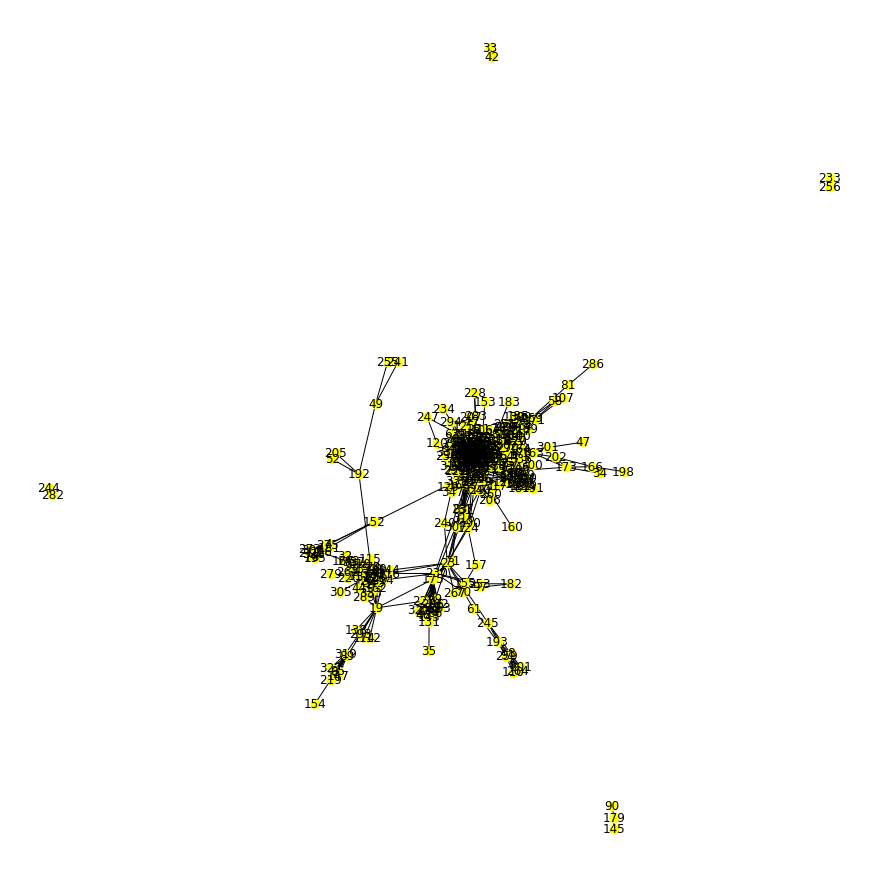

In [6]:
# building the graph

#edgelist is needed for read_edgelist
edge_df = open("facebook/0.edges", "rb")
G = nx.read_edgelist(edge_df)
display_graph(G)
        

In [7]:
#Building edge_dic

# getting nodes and edges for dataframe from graph
print(len(G.nodes))
print(len(G.edges))

node_list = list(np.unique(G.nodes))
edge_list = list(G.edges)


entries = []

# all_edges dictionary
edge_dict = dict()


for node1 in node_list:
    for node2 in node_list:
        if node1 != node2 and (node1, node2) not in edge_dict and (node2, node1) not in edge_dict:
            if (node1, node2) in edge_list:
                edge_dict[(node1, node2)] = 1
            elif (node2, node1) in edge_list:
                edge_dict[(node2, node1)] = 1
            else:
                edge_dict[(node1, node2)] = 0
                
print(len(edge_list))
print(len(edge_dict))                


333
2519
2519
55278


In [8]:
n2v = create_n2v_dict(G)

feat_dict = create_feat_dict(feat)

Computing transition probabilities: 100%|██████████| 333/333 [00:00<00:00, 343.32it/s]


In [8]:
# df = pd.DataFrame(columns = ['source_node', 'dest_node', 'edge_exists', 'source_n2v', 'dest_n2v', 'source_feat', 'dest_feat'])      

# index = 0
# for edge in edge_dict:
#     row = [edge[0], edge[1], edge_dict[edge], n2v[edge[0]], n2v[edge[1]], feat_dict[edge[0]], feat_dict[edge[1]]]
#     df.loc[index] = row
#     index += 1

In [9]:

# file = open('df.pickle', 'wb')
# pickle.dump(df, file)

file = open('df.pickle', 'rb')
df = pickle.load(file)
print(df.head)

<bound method NDFrame.head of       source_node dest_node edge_exists  \
0               1        10           0   
1               1       100           0   
2               1       101           0   
3               1       102           0   
4               1       103           0   
...           ...       ...         ...   
55273          96        98           0   
55274          96        99           0   
55275          97        98           0   
55276          97        99           0   
55277          98        99           0   

                                              source_n2v  \
0      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
1      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
2      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
3      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
4      [-0.0015783792, -0.0033764353, -0.0032837118, ...   
...                                                  ...   
55273  [-0.009693038, 0.004904478

In [10]:
#build train graph

train_graph = nx.Graph()
train_graph.add_nodes_from(node_list)


df_1 = df.loc[df['edge_exists'] == 1]
df_2 = df.loc[df['edge_exists'] == 0].sample(n = len(df_1), random_state = 1)
sample_df = df_1.append(df_2, ignore_index = True) 
print(sample_df.head)


<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            119         1           1   
1            126         1           1   
2            133         1           1   
3            194         1           1   
4            236         1           1   
...          ...       ...         ...   
5033          20        83           0   
5034         190       202           0   
5035          89        94           0   
5036         181       293           0   
5037           1       211           0   

                                             source_n2v  \
0     [-0.005113539, 0.0162464, -0.004656902, -0.000...   
1     [-0.008494396, 0.0031839241, 0.0006186882, 0.0...   
2     [0.0018095083, 0.01504459, -0.01150097, -0.010...   
3     [-0.0034687018, 0.00026966713, -0.00695016, -0...   
4     [-0.01406282, 0.009088622, -0.008409293, -0.01...   
...                                                 ...   
5033  [-0.0021234506, 0.018770823, -0.0072363117, -0

In [11]:
# Buildind dataframe for train graph
#print(node_list)
#sample_df['source_feat'] = 0
#sample_df['dest_feat'] = 0
print(sample_df.head)



<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            119         1           1   
1            126         1           1   
2            133         1           1   
3            194         1           1   
4            236         1           1   
...          ...       ...         ...   
5033          20        83           0   
5034         190       202           0   
5035          89        94           0   
5036         181       293           0   
5037           1       211           0   

                                             source_n2v  \
0     [-0.005113539, 0.0162464, -0.004656902, -0.000...   
1     [-0.008494396, 0.0031839241, 0.0006186882, 0.0...   
2     [0.0018095083, 0.01504459, -0.01150097, -0.010...   
3     [-0.0034687018, 0.00026966713, -0.00695016, -0...   
4     [-0.01406282, 0.009088622, -0.008409293, -0.01...   
...                                                 ...   
5033  [-0.0021234506, 0.018770823, -0.0072363117, -0

In [11]:
msk = np.random.rand(len(sample_df)) < 0.8

train_df = sample_df[msk]
test_df = sample_df[~msk]

print(len(sample_df))
print(len(train_df))
print(len(test_df))

5038
4061
977


In [12]:
X_train = list(train_df["source_n2v"]+train_df["dest_n2v"]+train_df["source_feat"]+train_df["dest_feat"])
y_train = list(train_df["edge_exists"])

X_test = list(test_df["source_n2v"]+test_df["dest_n2v"]+test_df["source_feat"]+test_df["dest_feat"])
y_test = list(test_df["edge_exists"])

In [128]:
clf = linear_model.SGDClassifier(max_iter=10000, random_state=1, tol=1e-5)
clf2 = LogisticRegression(random_state=1, max_iter=10000, tol=1e-5)
clf3 = LinearSVC(random_state=0, tol=1e-5, max_iter = 10000)


In [129]:
clf.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [130]:
#print(clf.predict(X_test))
print(clf.score(X_test, y_test))
print(clf2.score(X_test, y_test))
print(clf3.score(X_test, y_test))

0.7482088024564995
0.7400204708290685
0.7533265097236438


In [ ]:
# Neural Network

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(548,)),
    keras.layers.Dense(25, activation=tf.nn.relu),
    keras.layers.Dense(25, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=1)

Train on 4061 samples
Epoch 1/50
4061/4061 [==============================] - 14s 3ms/sample - loss: 0.5608 - accuracy: 0.7114s - l - ETA: 0s - loss: 0.5623 - ac
Epoch 2/50
4061/4061 [==============================] - 14s 4ms/sample - loss: 0.4341 - accuracy: 0.8047
Epoch 3/50
4061/4061 [==============================] - 12s 3ms/sample - loss: 0.3715 - accuracy: 0.8414
Epoch 4/50
1328/4061 [========>.....................] - ETA: 7s - loss: 0.3076 - accuracy: 0.8720 ETA: 7s - loss: 0.3073 - accu

In [140]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

977/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test accuracy: 0.80450356
